MODÉLISATION DES RÉGIMES DE VOLATILITÉ (MARKOV SWITCHING)
Données prêtes : 499 jours.
                        Markov Switching Model Results                        
Dep. Variable:             Volatility   No. Observations:                  499
Model:               MarkovRegression   Log Likelihood                 134.494
Date:                Wed, 31 Dec 2025   AIC                           -256.989
Time:                        18:51:54   BIC                           -231.713
Sample:                             0   HQIC                          -247.070
                                - 499                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1754      0.007     26.302  

/Users/sojoy/Desktop/NLP-Financial-Crisis-Modeling/quant_nlp_env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


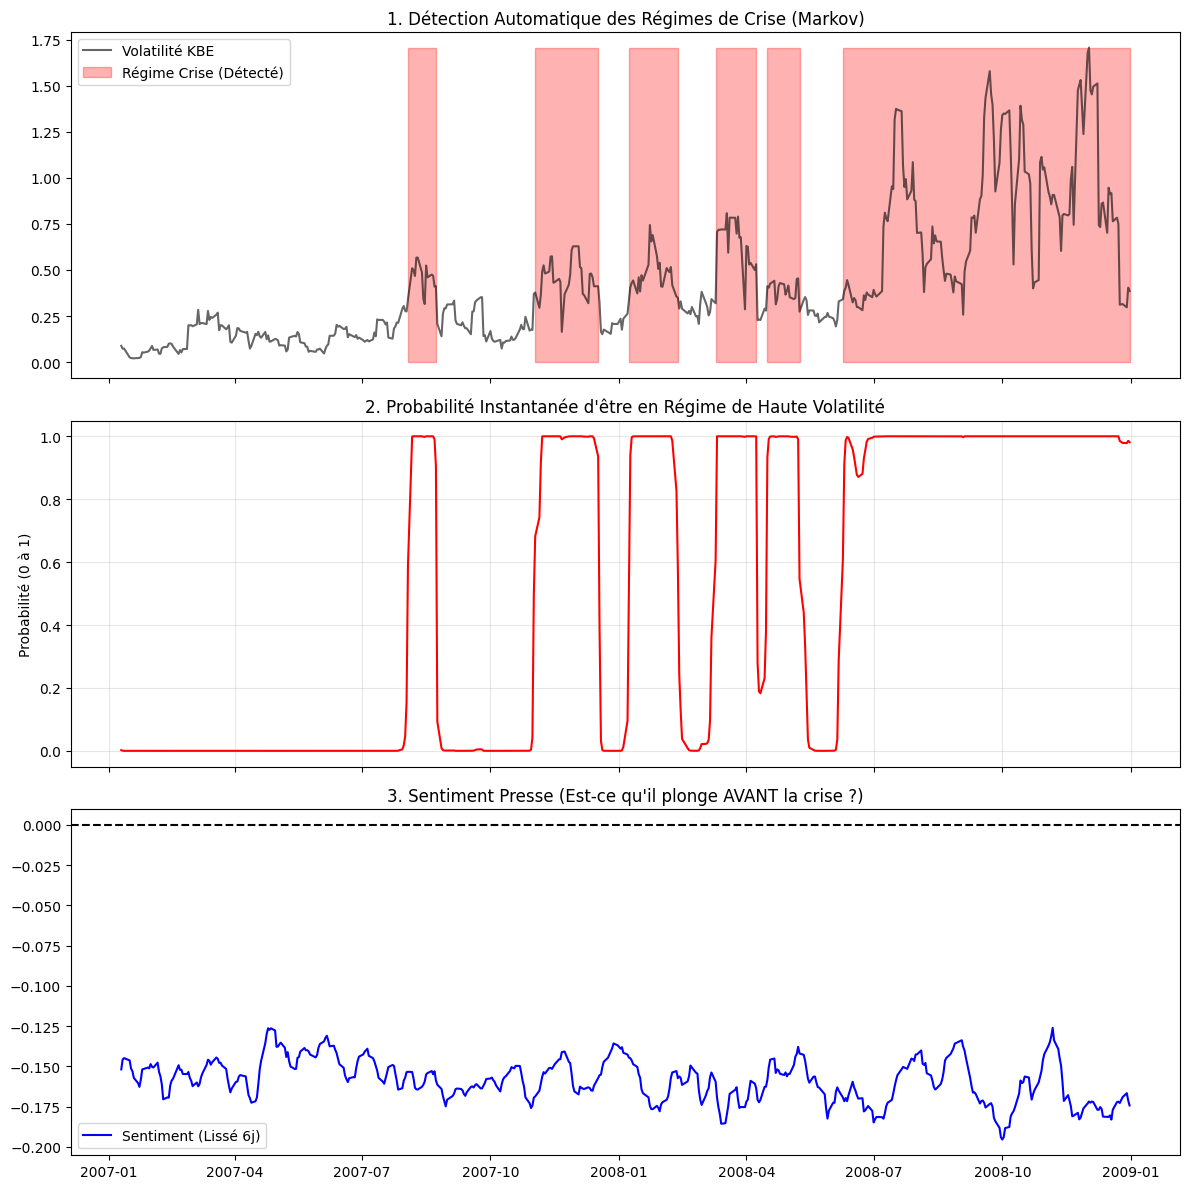

RÉSULTAT DU TEST PRÉDICTIF (Régression Logistique)
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -9.4696      1.305     -7.258      0.000     -12.027      -6.912
Sentiment_Lag6   -60.2032      8.227     -7.318      0.000     -76.328     -44.078
SUCCÈS (p=0.0000) : Le Sentiment est un prédicteur significatif du changement de régime !
Interprétation : Un sentiment plus négatif AUGMENTE la probabilité de basculer en régime de crise 6 jours plus tard.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
import statsmodels.api as sm

print("MODÉLISATION DES RÉGIMES DE VOLATILITÉ (MARKOV SWITCHING)")

# --- 1. CHARGEMENT & PRÉPARATION ---
# On reprend tes données gagnantes (KBE 6 jours)
df_vol = pd.read_csv('../data/financial_data_KBE.csv', parse_dates=['Date'], index_col='Date')
df_sent = pd.read_csv('../data/daily_sentiment_lm_final.csv', parse_dates=['date_only'], index_col='date_only')

# Fusion
df = pd.merge(df_vol[['Volatility']], df_sent[['mean']], left_index=True, right_index=True)

# Lissage du sentiment (Ta fenêtre optimale de 6 jours)
df['Sentiment_Smooth'] = df['mean'].rolling(window=6).mean()
df = df.dropna()

print(f"Données prêtes : {len(df)} jours.")

# --- 2. MODÈLE DE MARKOV (HMM) ---
# On modélise la Volatilité avec 2 régimes (k_regimes=2)
# switching_variance=True : On dit que la variance (le risque) change selon le régime.
model = MarkovRegression(df['Volatility'], k_regimes=2, trend='c', switching_variance=True)
res_markov = model.fit()

print(res_markov.summary())

# --- 3. ANALYSE DES RÉSULTATS ---
# Le modèle nous donne la probabilité d'être dans chaque régime à chaque instant.
# En général, le régime avec la plus forte variance est le régime "Crise".

# On récupère les variances estimées pour identifier qui est qui
regime_variances = res_markov.params[res_markov.params.index.str.contains('sigma2')]
# Au lieu de lire le texte, on demande : "A quelle position (0 ou 1) est le max ?"
# argmax renvoie l'indice entier directement.
crisis_regime_col = np.argmax(regime_variances.values) 

print(f"Le Régime {crisis_regime_col} a été identifié comme le régime de CRISE (Haute Volatilité).")

print(f"Le Régime {crisis_regime_col} a été identifié comme le régime de CRISE (Haute Volatilité).")

# Probabilités lissées d'être en crise
df['Prob_Crisis'] = res_markov.smoothed_marginal_probabilities[crisis_regime_col]

# --- 4. VISUALISATION IMPACTANTE ---
fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# Graphe 1 : Volatilité Réelle + Zones de Crise détectées
axes[0].plot(df.index, df['Volatility'], color='black', alpha=0.6, label='Volatilité KBE')
axes[0].fill_between(df.index, 0, df['Volatility'].max(), where=df['Prob_Crisis'] > 0.5, color='red', alpha=0.3, label='Régime Crise (Détecté)')
axes[0].set_title("1. Détection Automatique des Régimes de Crise (Markov)")
axes[0].legend()

# Graphe 2 : Probabilité de Crise
axes[1].plot(df.index, df['Prob_Crisis'], color='red', label='Probabilité de Crise (Markov)')
axes[1].set_ylabel("Probabilité (0 à 1)")
axes[1].set_title("2. Probabilité Instantanée d'être en Régime de Haute Volatilité")
axes[1].grid(True, alpha=0.3)

# Graphe 3 : Sentiment (Inversé pour la corrélation visuelle)
# On inverse l'axe du sentiment : Sentiment bas (peur) = Courbe haute
axes[2].plot(df.index, df['Sentiment_Smooth'], color='blue', label='Sentiment (Lissé 6j)')
axes[2].set_title("3. Sentiment Presse (Est-ce qu'il plonge AVANT la crise ?)")
axes[2].axhline(0, color='black', linestyle='--')
axes[2].legend()

plt.tight_layout()
plt.show()

# --- 5. TEST STATISTIQUE FINAL (LOGIT) ---
# Question : Est-ce que le Sentiment d'il y a 6 jours prédit la PROBABILITÉ d'être en crise aujourd'hui ?
# On crée une variable binaire : 1 si on est en crise, 0 sinon
df['Is_Crisis'] = (df['Prob_Crisis'] > 0.5).astype(int)

# On décale le sentiment de 6 jours (Lag)
df['Sentiment_Lag6'] = df['Sentiment_Smooth'].shift(6)
df_logit = df.dropna()

# Régression Logistique : P(Crise) = f(Sentiment_Lag6)
logit_mod = sm.Logit(df_logit['Is_Crisis'], sm.add_constant(df_logit['Sentiment_Lag6']))
logit_res = logit_mod.fit(disp=0)

print("RÉSULTAT DU TEST PRÉDICTIF (Régression Logistique)")
print(logit_res.summary().tables[1])

p_val_logit = logit_res.pvalues['Sentiment_Lag6']
if p_val_logit < 0.05:
    print(f"SUCCÈS (p={p_val_logit:.4f}) : Le Sentiment est un prédicteur significatif du changement de régime !")
    coef = logit_res.params['Sentiment_Lag6']
    direction = "AUGMENTE" if coef < 0 else "DIMINUE" 
    print(f"Interprétation : Un sentiment plus négatif {direction} la probabilité de basculer en régime de crise 6 jours plus tard.")
else:
    print(f"PAS DE LIEN (p={p_val_logit:.4f}) : Le sentiment ne semble pas déclencher le changement de régime.")